In [2]:
from pathlib import Path
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Error Analysis

## Data Preparation

In [3]:
root_path = Path("results")

In [4]:
models = [m for m in root_path.iterdir() if m.is_dir()]

In [18]:
summary = {}

In [19]:
for model in tqdm(models):
    tasks = [t for t in model.iterdir() if t.is_dir()]
    if summary.get(model.name) is None:
        summary[model.name] = {}
    for task in tqdm(tasks):
        if summary[model.name].get(task.name) is None:
            summary[model.name][task.name] = {}
        prompt_engineering = [p for p in task.iterdir() if p.is_dir()]
        for prompt in tqdm(prompt_engineering):
            if summary[model.name][task.name].get(prompt.name) is None:
                summary[model.name][task.name][prompt.name] = {}
            prompt_name = prompt.name
            outputs = [f for f in prompt.iterdir() if f.is_file() and f.suffix == ".json"]
            for output in tqdm(outputs):
                with open(output, "r") as f:
                    data = json.load(f)
                    if summary[model.name][task.name][prompt_name].get("total") is None:
                        summary[model.name][task.name][prompt_name]["total"] = 0
                    if summary[model.name][task.name][prompt_name].get("correct") is None:
                        summary[model.name][task.name][prompt_name]["correct"] = 0
                    if summary[model.name][task.name][prompt_name].get("incorrect") is None:
                        summary[model.name][task.name][prompt_name]["incorrect"] = 0

                    if not data.get("is_correct"):
                        if summary[model.name][task.name][prompt_name].get("incorrect_files") is None:
                            summary[model.name][task.name][prompt_name]["incorrect_files"] = []
                        summary[model.name][task.name][prompt_name]["incorrect_files"].append(output)
                        summary[model.name][task.name][prompt_name]["incorrect"] += 1
                    else:
                        summary[model.name][task.name][prompt_name]["correct"] += 1
                    summary[model.name][task.name][prompt_name]["total"] += 1

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/1201 [00:00<?, ?it/s]


100%|██████████| 1201/1201 [00:00<00:00, 9377.62it/s][A


 25%|██▌       | 1/4 [00:00<00:00,  6.98it/s]


100%|██████████| 1201/1201 [00:00<00:00, 38199.72it/s]



100%|██████████| 1201/1201 [00:00<00:00, 39498.48it/s]



100%|██████████| 1201/1201 [00:00<00:00, 40027.96it/s]


100%|██████████| 4/4 [00:00<00:00, 15.74it/s]

 12%|█▎        | 1/8 [00:00<00:01,  3.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 1001/1001 [00:00<00:00, 38904.16it/s]



100%|██████████| 1001/1001 [00:00<00:00, 35280.02it/s]



100%|██████████| 1001/1001 [00:00<00:00, 38343.50it/s]



100%|██████████| 1001/1001 [00:00<00:00, 38923.64it/s]


100%|██████████| 4/4 [00:00<00:00, 31.16it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 1437/1437 [00:00<00:00, 38408.25it/s]



100%|██████████| 1437/1437 [00:00<00:00, 3

In [22]:
summary_str = {}
for model in summary:
    summary_str[model] = {}
    for task in summary[model]:
        summary_str[model][task] = {}
        for prompt in summary[model][task]:
            summary_str[model][task][prompt] = {}
            for key in summary[model][task][prompt]:
                if isinstance(summary[model][task][prompt][key], list):
                    summary_str[model][task][prompt][key] = [str(p) for p in summary[model][task][prompt][key]]
                else:
                    summary_str[model][task][prompt][key] = summary[model][task][prompt][key]

In [23]:
with open("error_summary.json", "w") as f:
    json.dump(summary_str, f, indent=4)

## Categorize the errors

In [65]:
with open("error_summary.json", "r") as f:
    error_summary = json.load(f)

In [66]:
for model in error_summary:
    for task in error_summary[model]:
        for prompt in error_summary[model][task]:
            if error_summary[model][task][prompt].get("incorrect_files") is not None:
                error_summary[model][task][prompt]["incorrect_files"] = [Path(p) for p in
                                                                         error_summary[model][task][prompt][
                                                                             "incorrect_files"]]

In [67]:
error_categories = {}

Three error categories:
1. Empty response: The model did not return any response.
2. Incorrect response: The model returned a response but it was incorrect.
3. Error response: The model returned an error message.

In [68]:
for model in tqdm(error_summary):
    if model in ["llama-2-7b", "llama-2-chat-7b"]:  # Skip ablation studies
        continue

    if error_categories.get(model) is None:
        error_categories[model] = {}
    for task in tqdm(error_summary[model]):
        if error_categories[model].get(task) is None:
            error_categories[model][task] = {}
        for pe in tqdm(error_summary[model][task]):
            if pe in ["null-shot-after", "null-shot-v1", "null-shot-v2", "null-shot-v3"]:  # Skip ablation studies
                continue

            if error_categories[model][task].get(pe) is None:
                error_categories[model][task][pe] = {}

            if error_summary[model][task][pe].get("incorrect_files") is not None:
                error_categories[model][task][pe]["empty_response"] = []
                error_categories[model][task][pe]["incorrect_response"] = []
                error_categories[model][task][pe]["error_response"] = []
                error_categories[model][task][pe]["total"] = error_summary[model][task][pe]["total"]
                error_categories[model][task][pe]["correct"] = error_summary[model][task][pe]["correct"]

                for file in tqdm(error_summary[model][task][pe]["incorrect_files"]):
                    with open(file, "r") as f:
                        data = json.load(f)
                        if data.get("response") is None:
                            continue
                        elif data.get("response") == "":
                            error_categories[model][task][pe]["empty_response"].append(file)
                        elif not data.get("is_correct"):
                            error_categories[model][task][pe]["incorrect_response"].append(file)
                        elif "ERROR:" in data.get("response"):
                            error_categories[model][task][pe]["error_response"].append(file)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 689/689 [00:00<00:00, 36063.49it/s]



100%|██████████| 692/692 [00:00<00:00, 36691.21it/s]



100%|██████████| 679/679 [00:00<00:00, 37544.92it/s]



100%|██████████| 4/4 [00:00<00:00, 51.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 299/299 [00:00<00:00, 33523.94it/s]



100%|██████████| 310/310 [00:00<00:00, 33487.89it/s]



100%|██████████| 295/295 [00:00<00:00, 35418.78it/s]



100%|██████████| 4/4 [00:00<00:00, 103.40it/s]

 25%|██▌       | 2/8 [00:00<00:00, 16.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 381/381 [00:00<00:00, 33377.12it/s]



100%|██████████| 404/404 [00:00<00:00, 37016.38it/s]



100%|██████████| 409/409 [00:00<00:00, 36401.01it/s]



100%|██████████| 4/4 [00:00<00:00, 84.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 969/969 [00:00<00:00, 39417.70it/s]



100%|██████████| 914/914 [00:00<00:00, 38026.40it/

In [69]:
summarized_error_categories = {}
for model in error_categories:
    summarized_error_categories[model] = {}
    for task in error_categories[model]:
        summarized_error_categories[model][task] = {}
        for pe in error_categories[model][task]:
            summarized_error_categories[model][task][pe] = {
                "total": error_categories[model][task][pe]["total"],
                "correct": error_categories[model][task][pe]["correct"],
            }
            for category in error_categories[model][task][pe]:
                if category in ["total", "correct"]:
                    continue
                summarized_error_categories[model][task][pe][category] = len(
                    error_categories[model][task][pe][category])

Are there any pairs that has non-zero error?

In [70]:
count = 0
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            if summarized_error_categories[model][task][pe]["error_response"] != 0:
                count += 1
                
print(count)

0


What is the average `empty_response` rate for each pair?

In [71]:
temp = []
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            temp.append({
                "model": model,
                "task": task,
                "pe": pe,
                "empty_response": summarized_error_categories[model][task][pe]["empty_response"] /
                                  summarized_error_categories[model][task][pe]["total"]
            })

temp = sorted(temp, key=lambda x: x["empty_response"], reverse=True)
for t in temp:
    print(t)

{'model': 'palm-2-text', 'task': 'strategyqa', 'pe': 'zero-shot', 'empty_response': 0.15888258402444347}
{'model': 'palm-2-text', 'task': 'race-h', 'pe': 'zero-shot-cot', 'empty_response': 0.1577593598170906}
{'model': 'palm-2-text', 'task': 'race-h', 'pe': 'zero-shot', 'empty_response': 0.15204344098313805}
{'model': 'palm-2-text', 'task': 'strategyqa', 'pe': 'zero-shot-cot', 'empty_response': 0.14054997817546921}
{'model': 'palm-2-text', 'task': 'race-h', 'pe': 'null-shot-cot', 'empty_response': 0.13175192912260647}
{'model': 'palm-2-text', 'task': 'race-h', 'pe': 'null-shot', 'empty_response': 0.11288939697056302}
{'model': 'palm-2-text', 'task': 'triviaqa', 'pe': 'zero-shot', 'empty_response': 0.1018981018981019}
{'model': 'palm-2-text', 'task': 'winogrande', 'pe': 'zero-shot', 'empty_response': 0.09779179810725552}
{'model': 'palm-2-text', 'task': 'winogrande', 'pe': 'zero-shot-cot', 'empty_response': 0.09542586750788644}
{'model': 'palm-2-text', 'task': 'anli', 'pe': 'zero-shot',

In [72]:
count = 0
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            if model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
                if summarized_error_categories[model][task][pe]["empty_response"] != 0:
                    count += 1

print(count)

0


In [73]:
df = pd.DataFrame(temp)
df.head()

,model,task,pe,empty_response
0,palm-2-text,strategyqa,zero-shot,0.158883
1,palm-2-text,race-h,zero-shot-cot,0.157759
2,palm-2-text,race-h,zero-shot,0.152043
3,palm-2-text,strategyqa,zero-shot-cot,0.140550
4,palm-2-text,race-h,null-shot-cot,0.131752


### Visualize

In [74]:
sns.set(style="whitegrid")
colors = ["#88AB8E", "#C84361", "#8ACDD7"]
sns.color_palette(colors)

[(0.5333333333333333, 0.6705882352941176, 0.5568627450980392),
 (0.7843137254901961, 0.2627450980392157, 0.3803921568627451),
 (0.5411764705882353, 0.803921568627451, 0.8431372549019608)]

In [75]:
import warnings

warnings.filterwarnings("ignore")

In [76]:
plot_data = {}
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            if plot_data.get(model) is None:
                plot_data[model] = {}
            if plot_data[model].get(task) is None:
                plot_data[model][task] = {}
            if plot_data[model][task].get(pe) is None:
                plot_data[model][task][pe] = {}
            for category in summarized_error_categories[model][task][pe]:
                plot_data[model][task][pe] = {
                    "Correct": summarized_error_categories[model][task][pe]["correct"],
                    "Incorrect": summarized_error_categories[model][task][pe]["incorrect_response"],
                    "Empty": summarized_error_categories[model][task][pe]["empty_response"]
                }

In [77]:
model_names = {
    "gpt-3.5-turbo": "GPT-3.5 Turbo",
    "gpt-4-turbo": "GPT-4 Turbo",
    "palm-2-text": "PaLM 2",
    "palm-2-chat": "PaLM 2 for Chat",
    "llama-2-7b": "Llama 2 - 7B",
    "llama-2-chat-7b": "Llama 2 Chat - 7B",
}

task_names = {
    "anli": "ANLI",
    "aqua": "AQuA-RAT",
    "gsm8k": "GSM8K",
    "race-m": "RACE (Middle school)",
    "race-h": "RACE (High school)",
    "strategyqa": "StrategyQA",
    "triviaqa": "TriviaQA",
    "winogrande": "WinoGrande",
}

pe_names = {
    "zero-shot": "Zero-Shot",
    "null-shot": "Null-Shot",
    "zero-shot-cot": "Zero-Shot Chain-of-Thought",
    "null-shot-cot": "Null-Shot Chain-of-Thought",
}

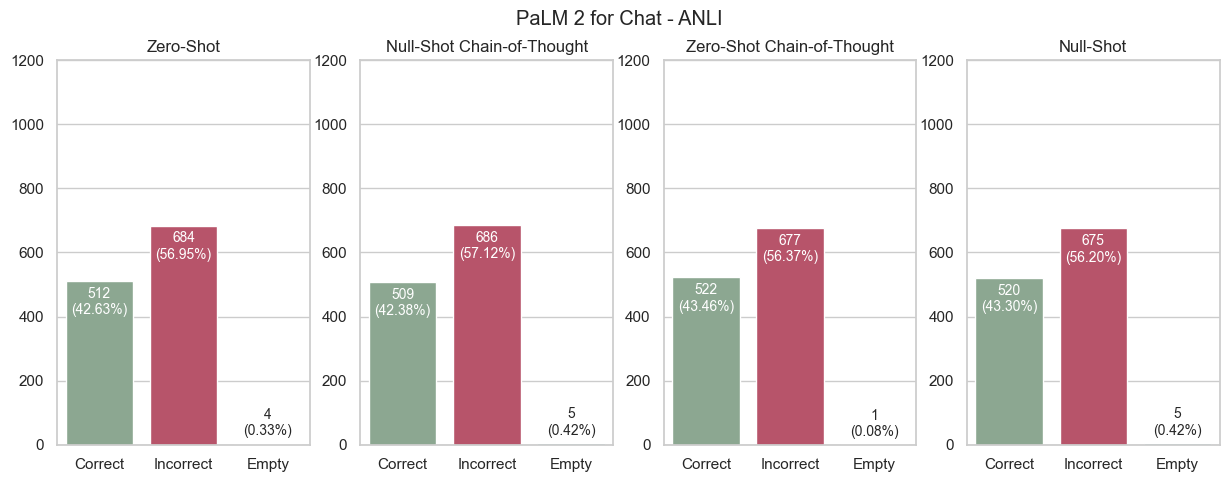

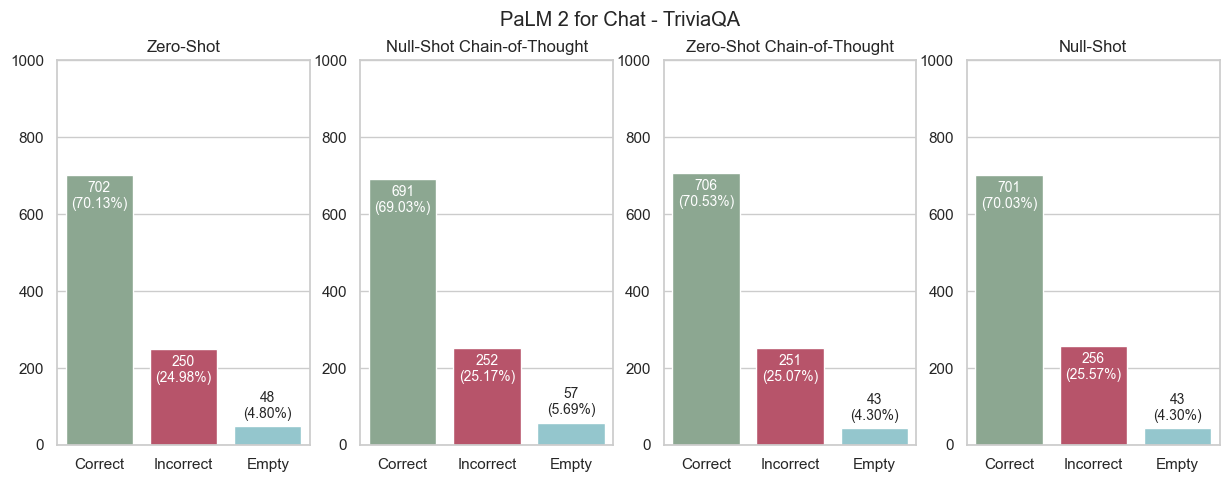

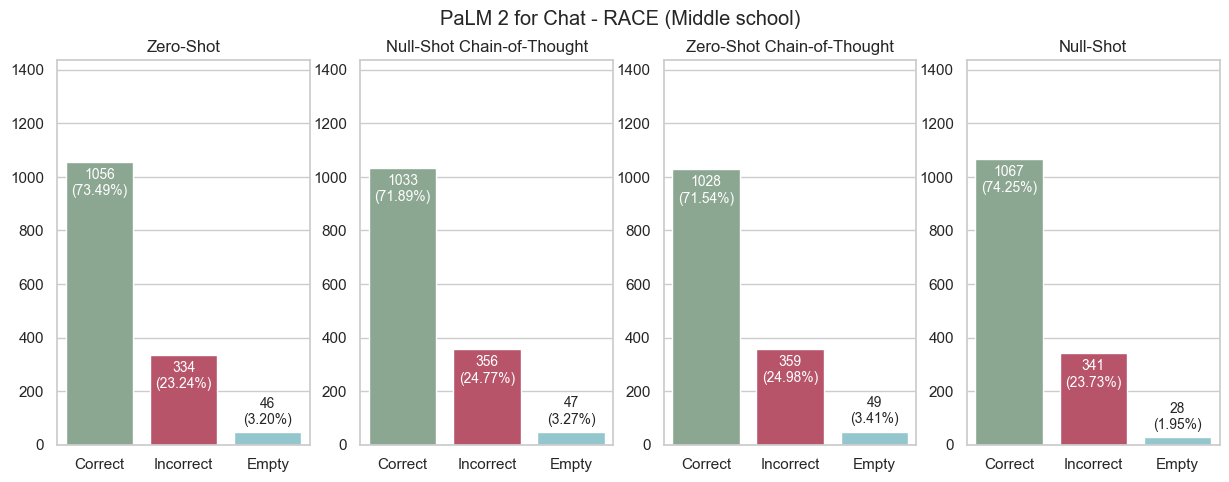

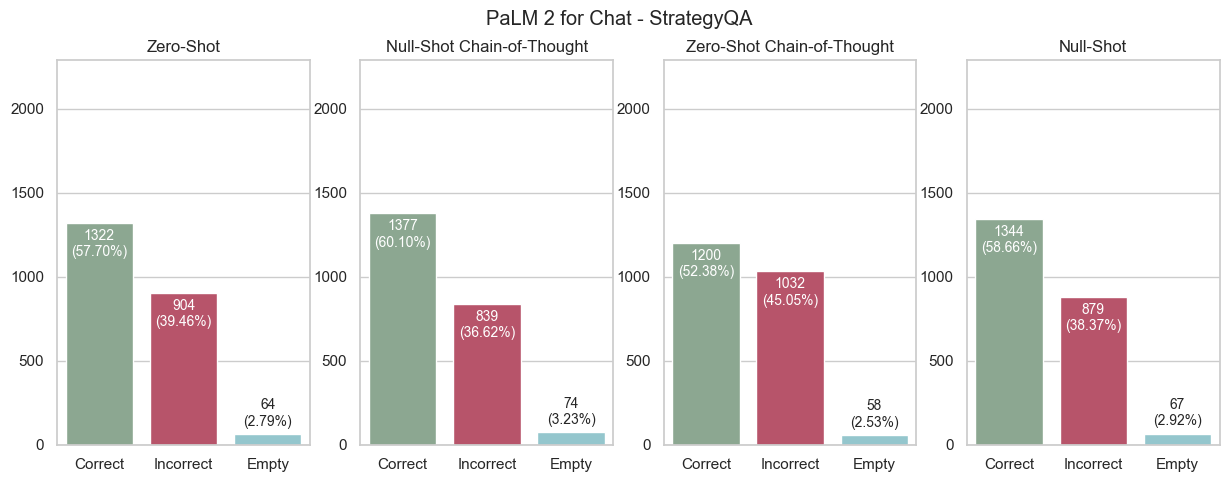

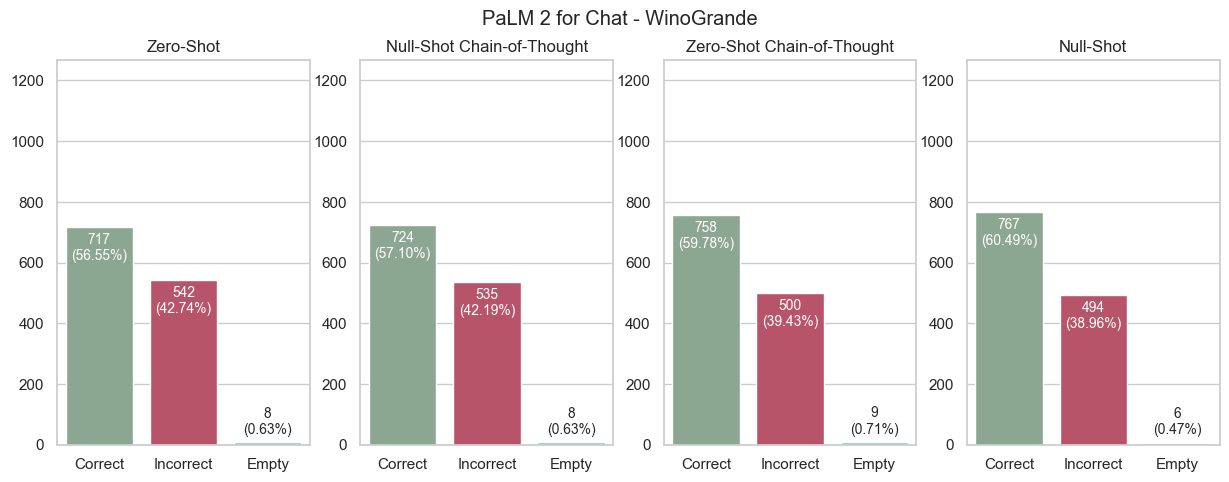

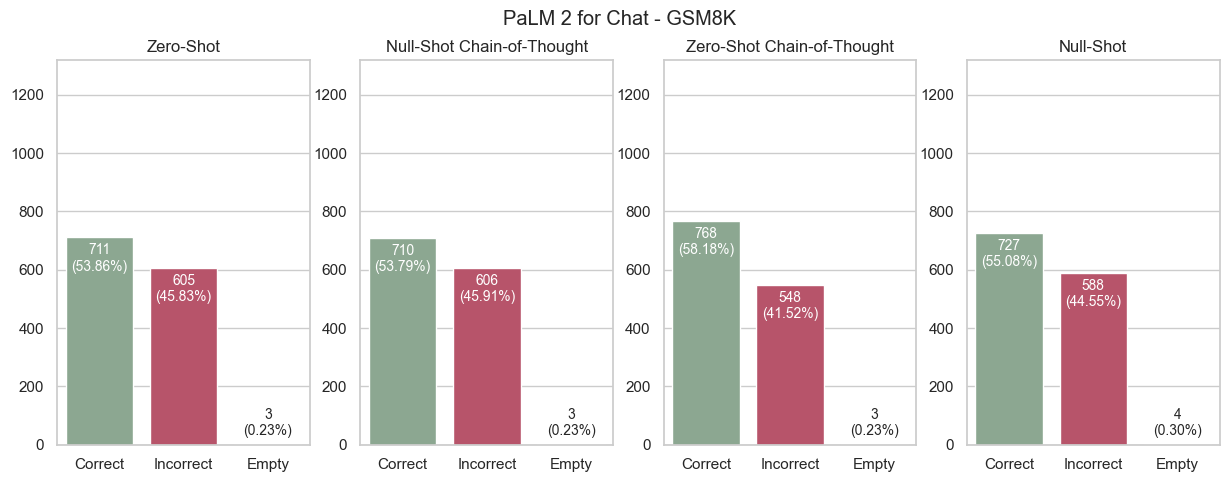

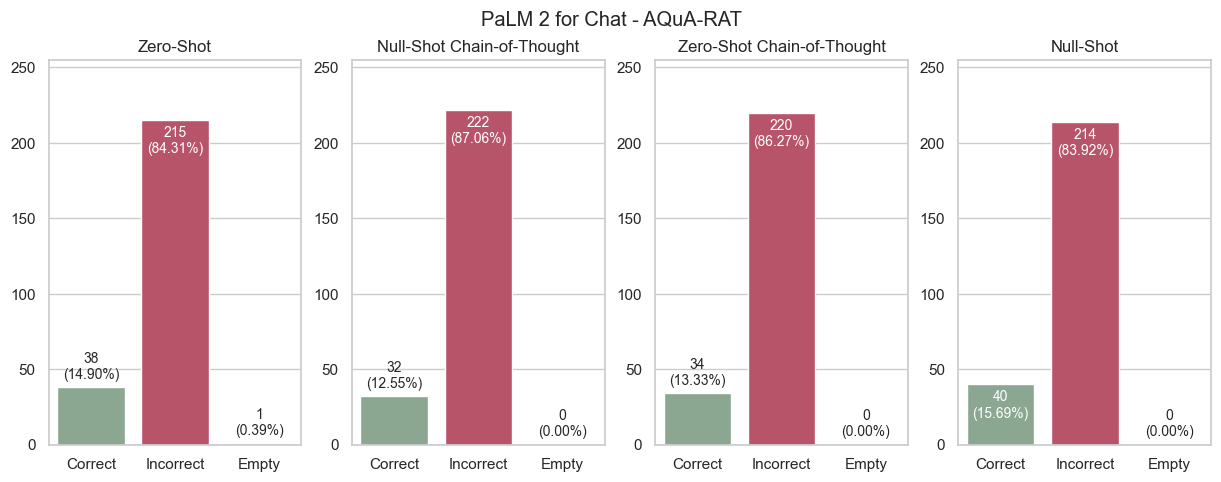

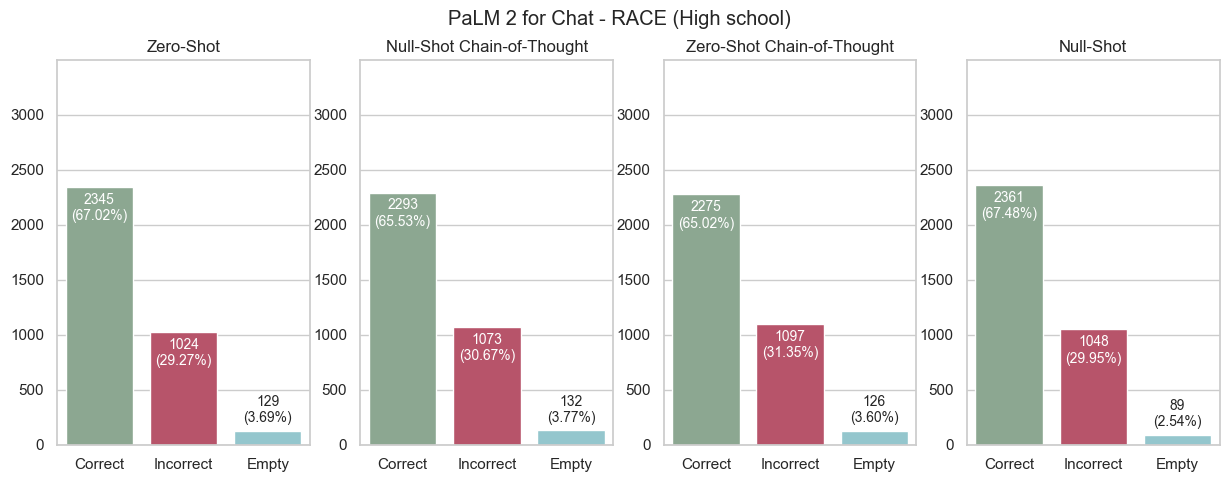

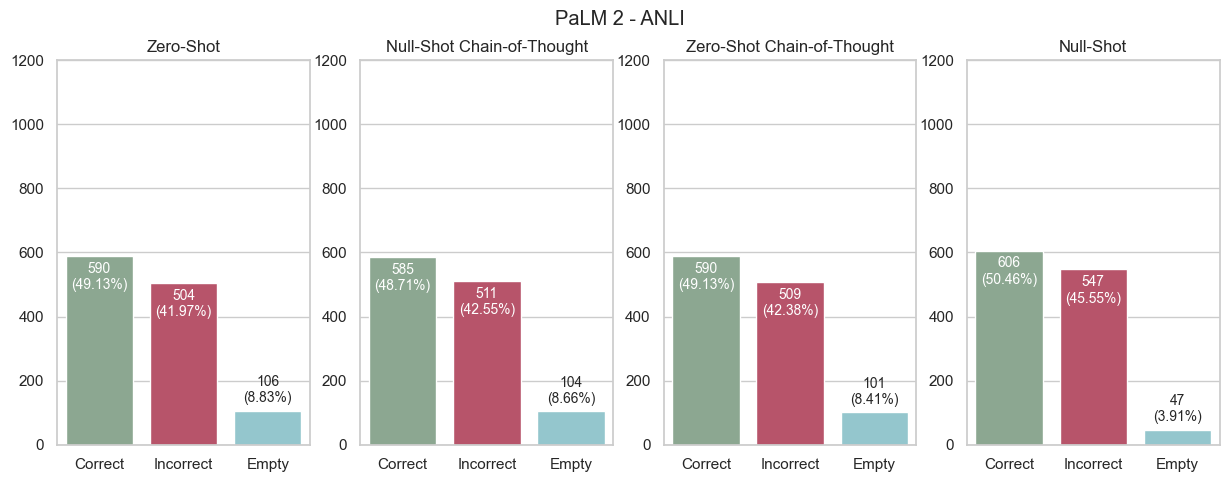

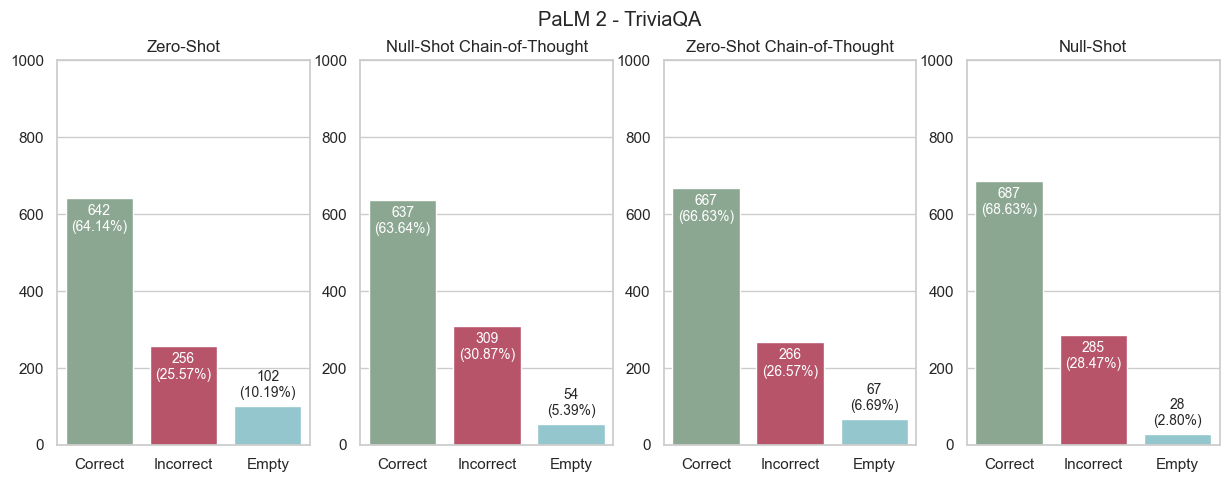

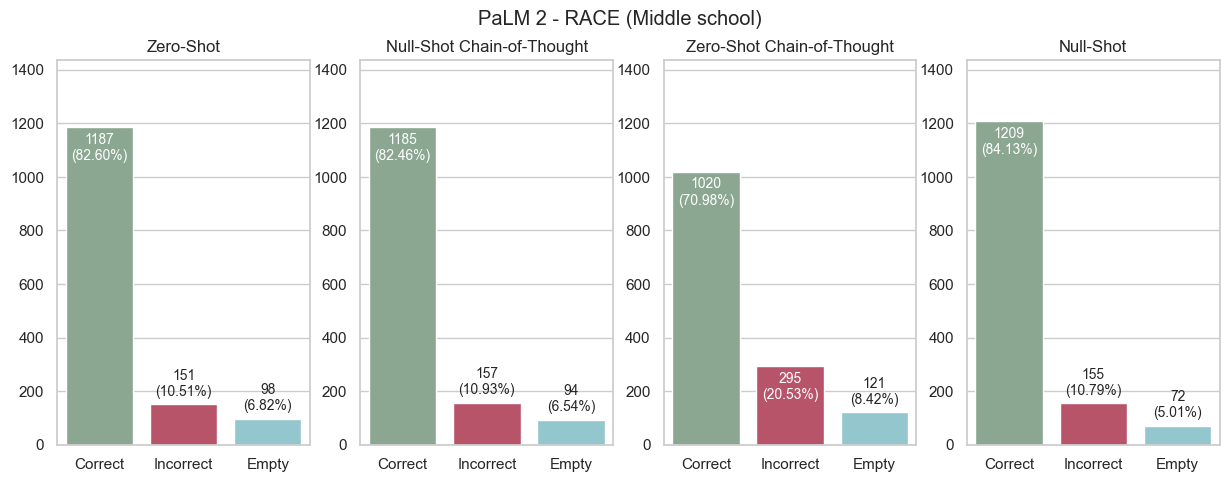

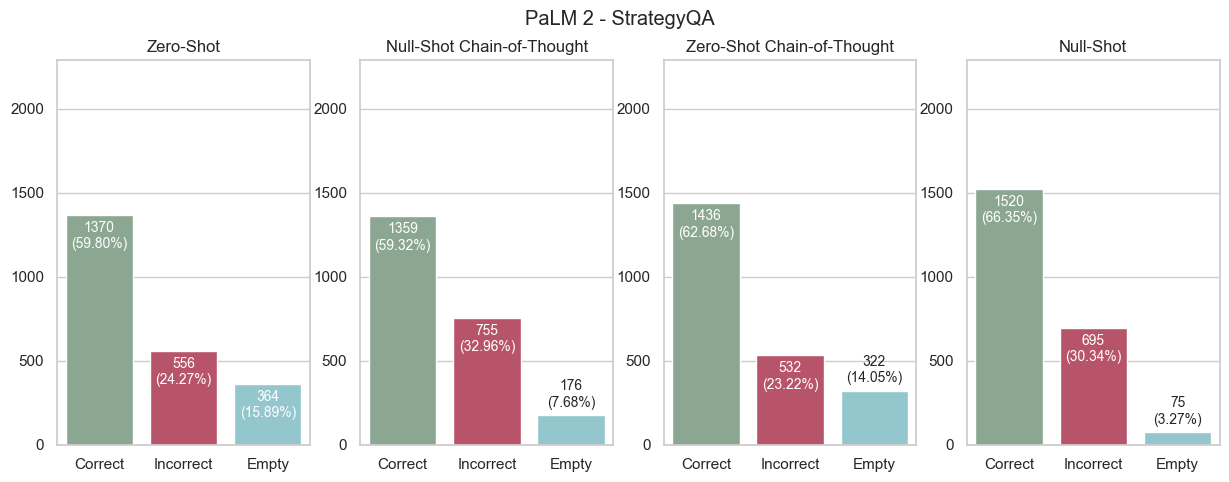

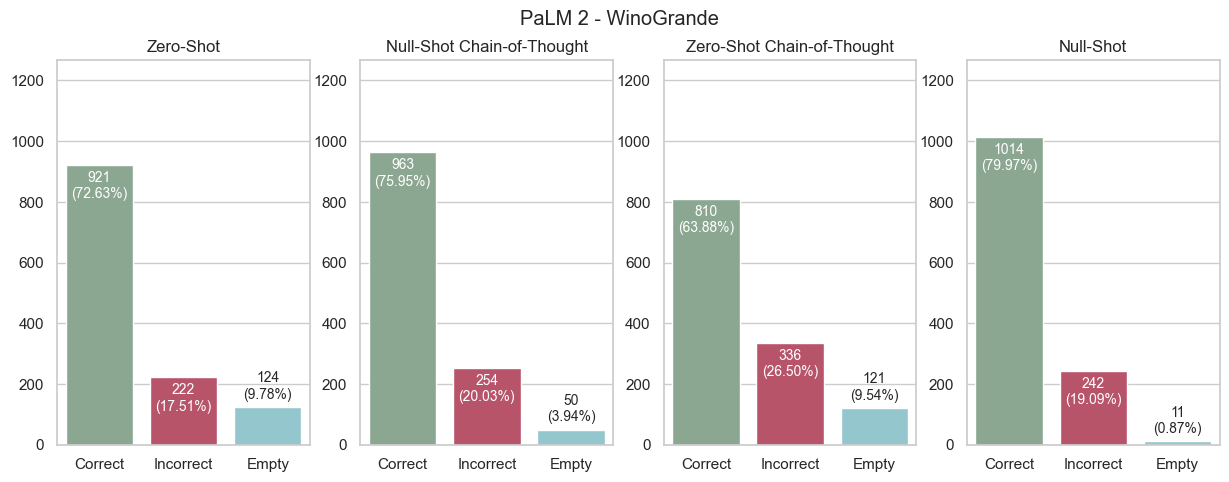

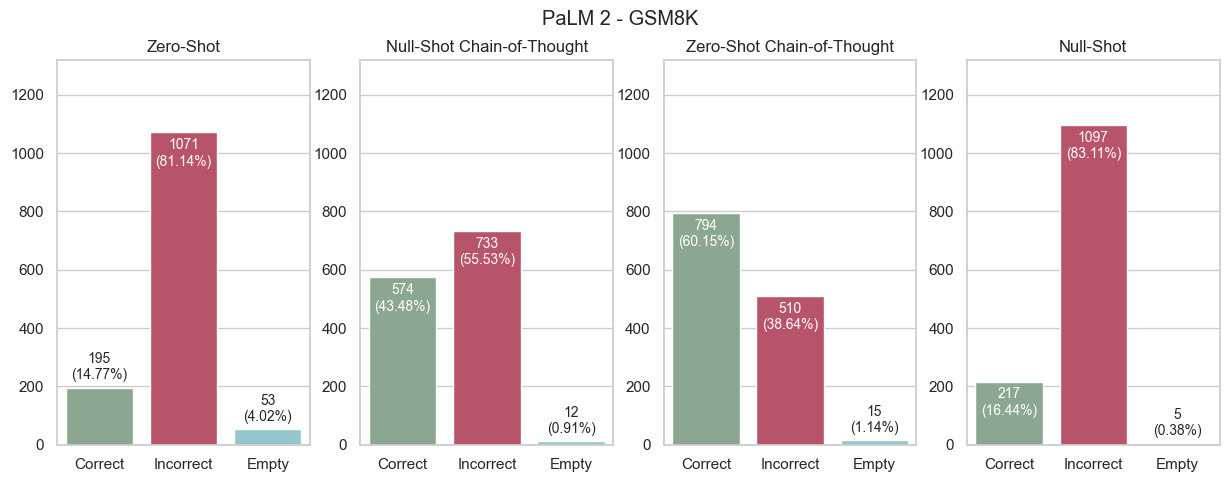

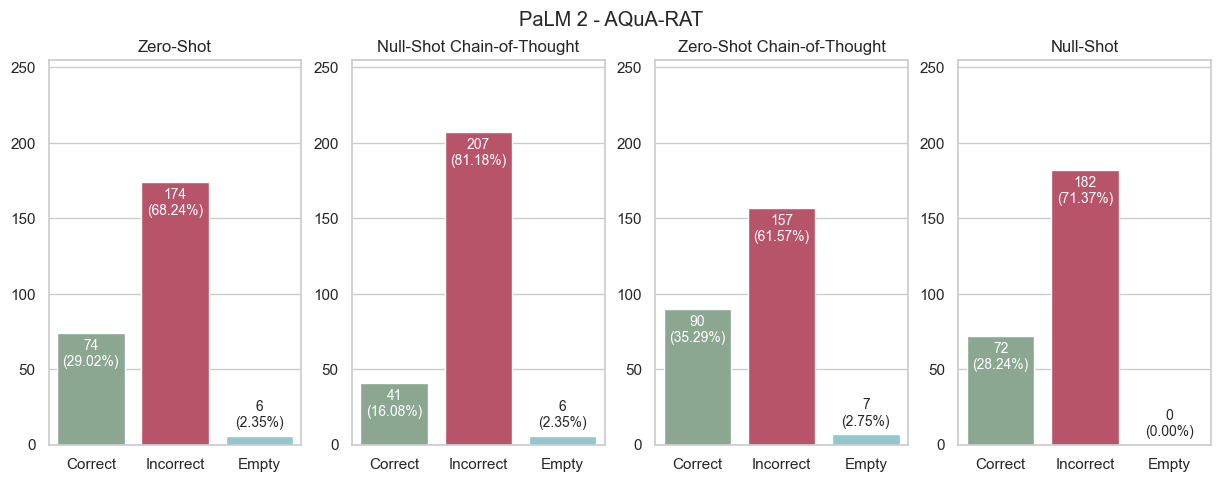

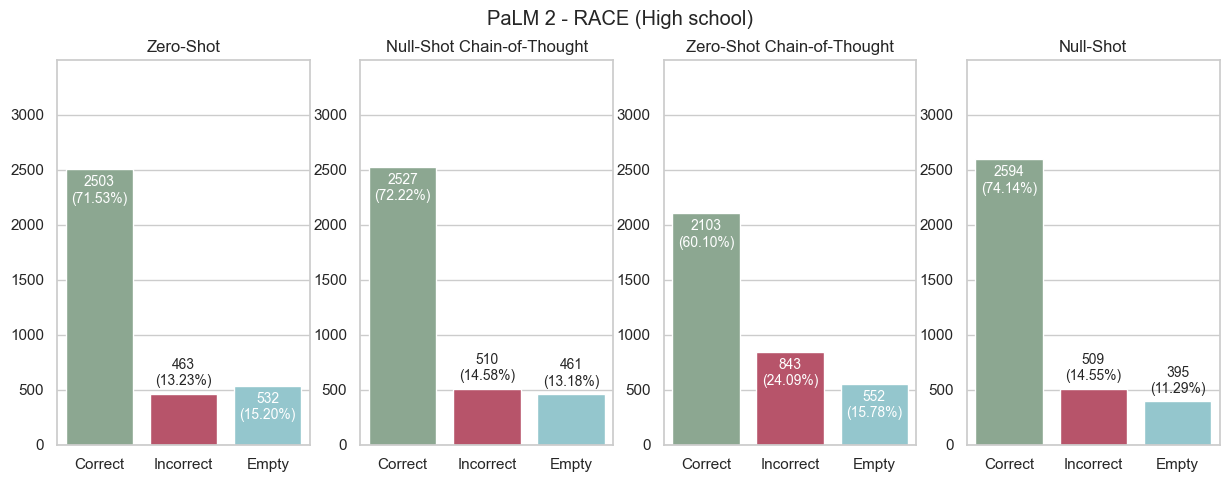

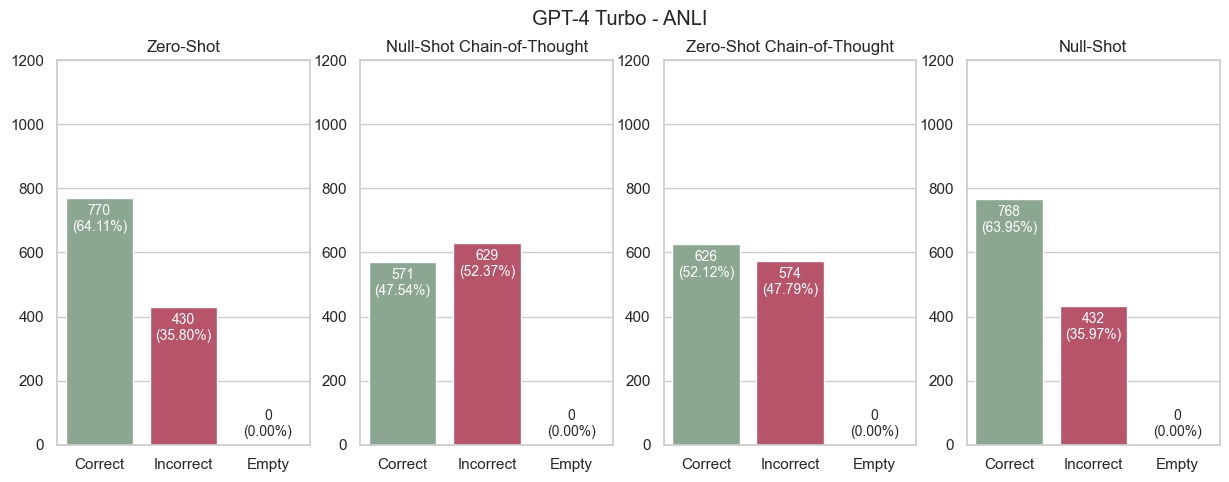

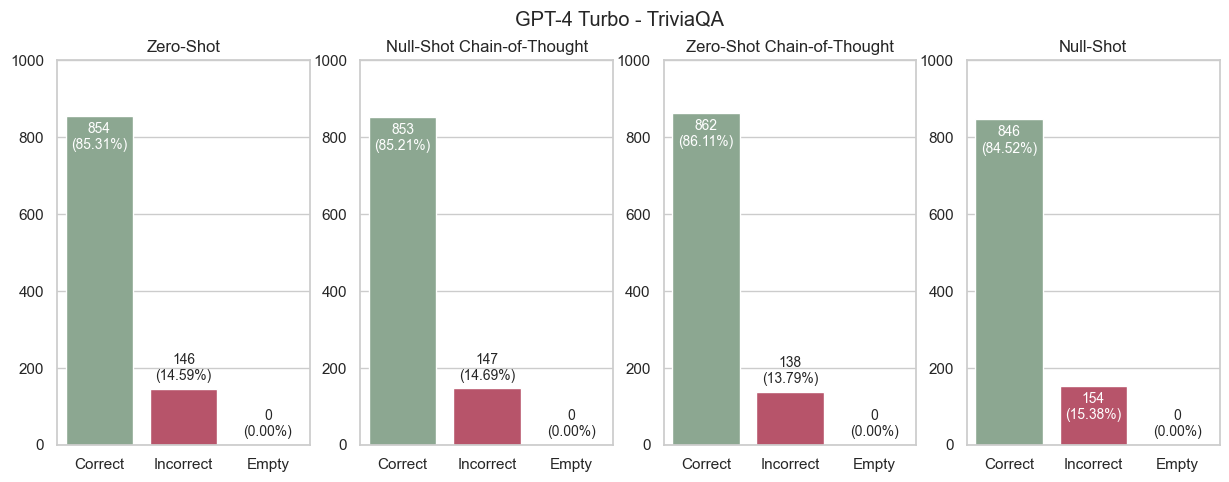

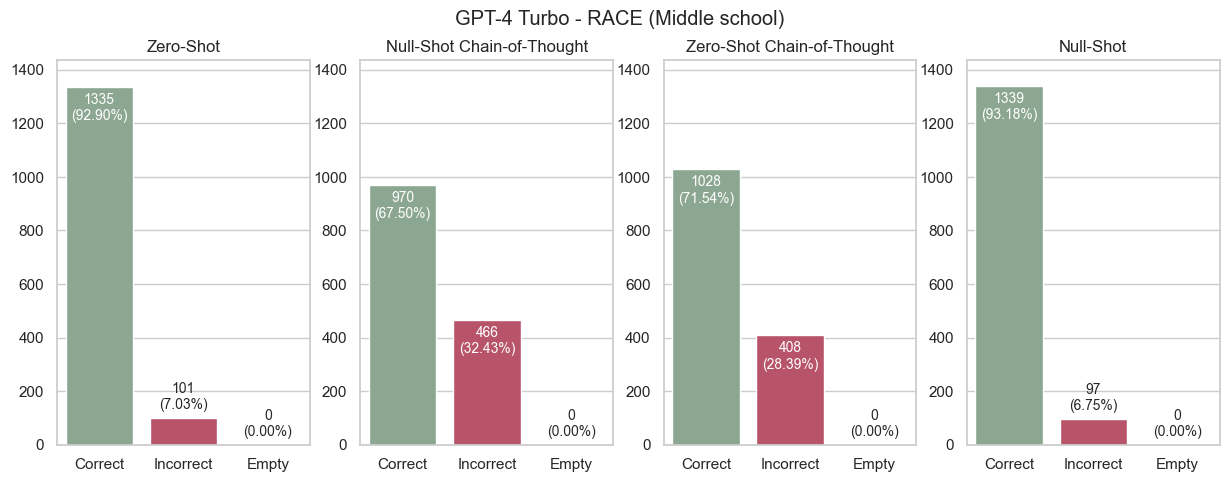

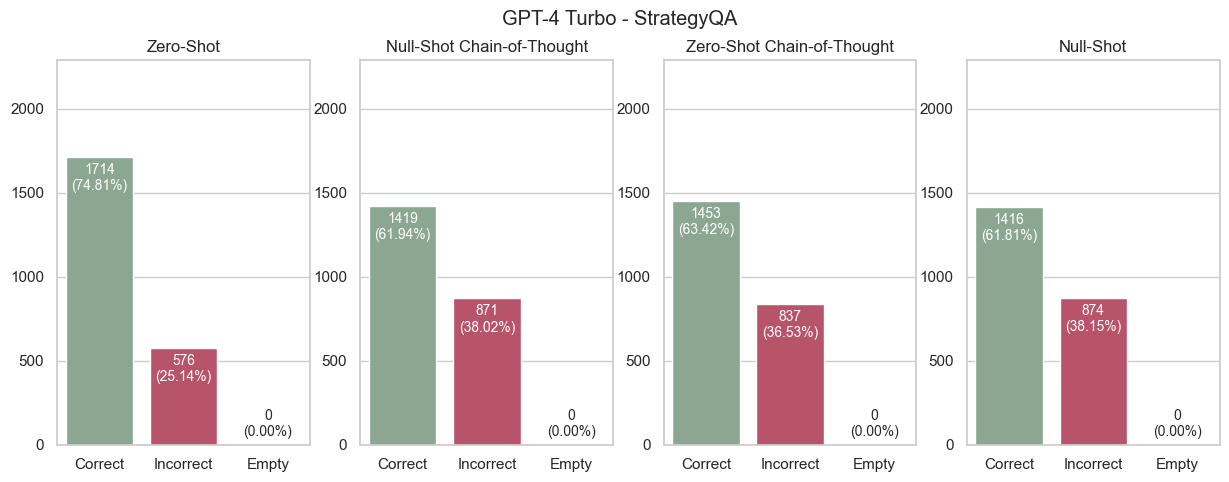

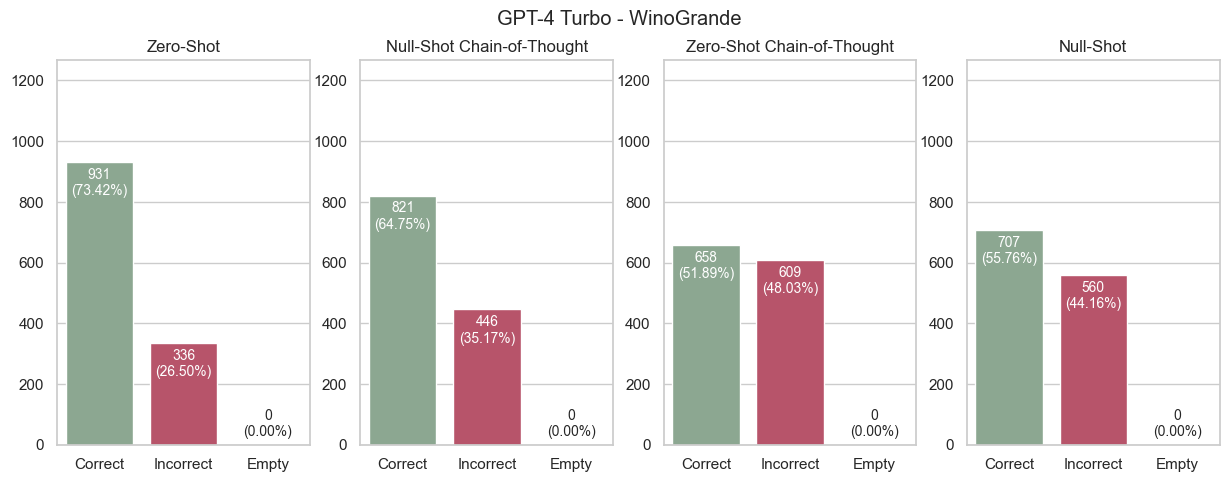

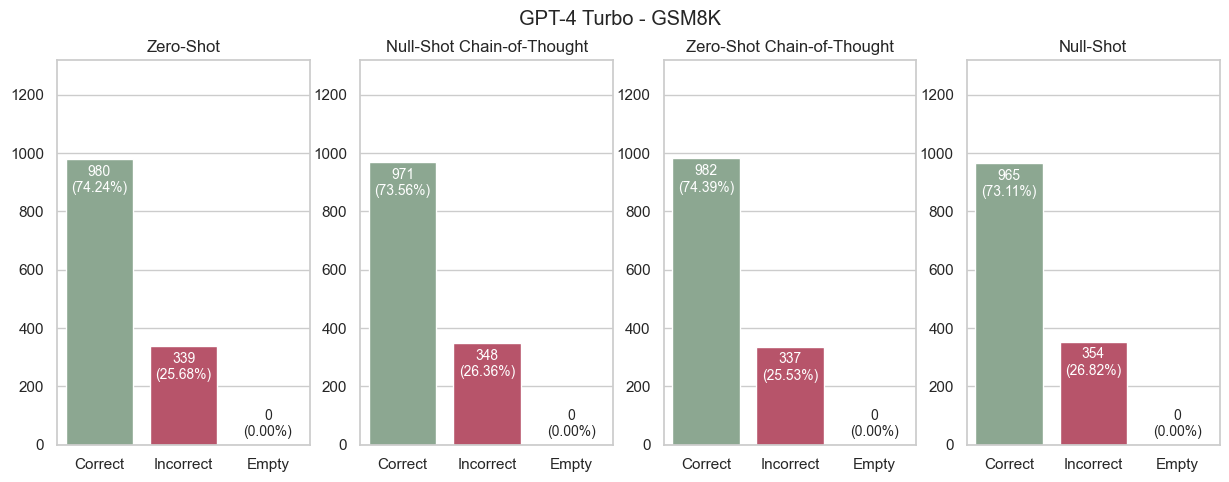

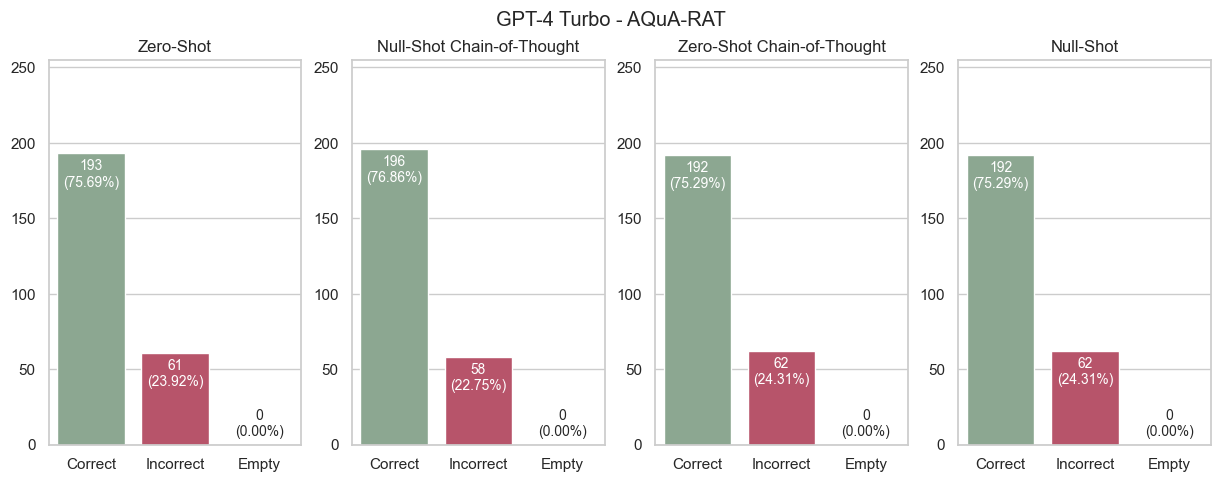

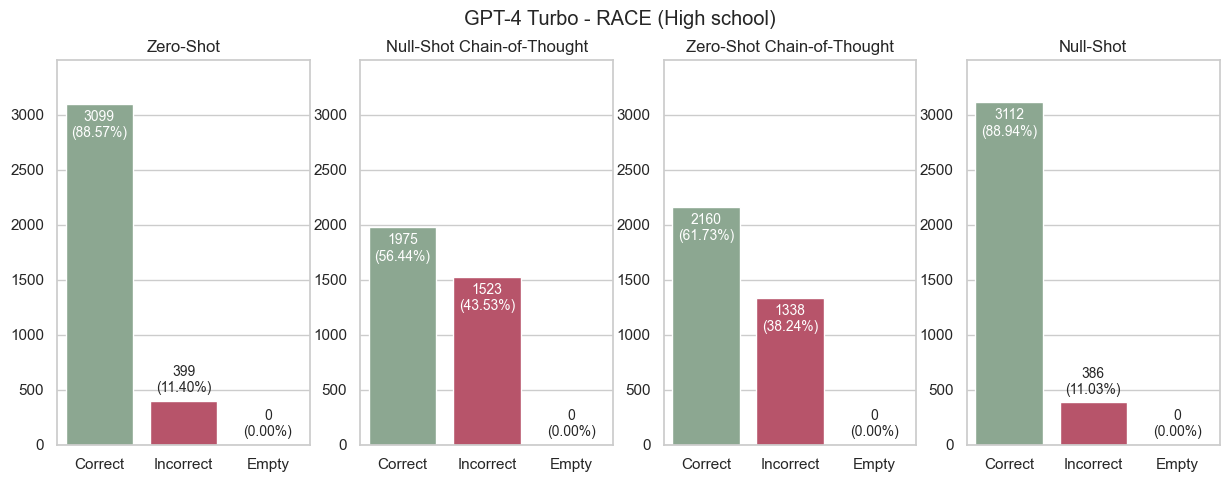

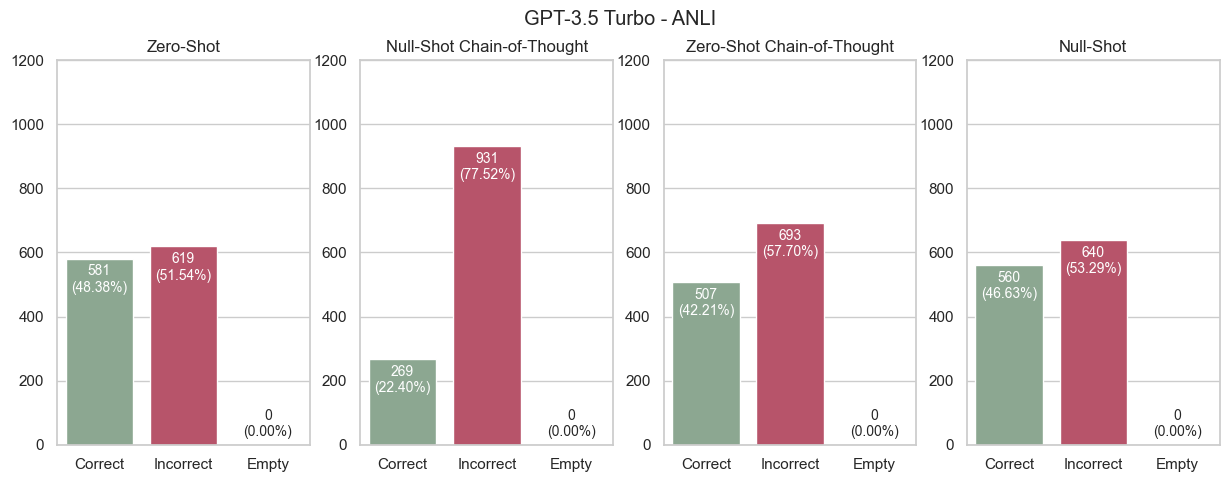

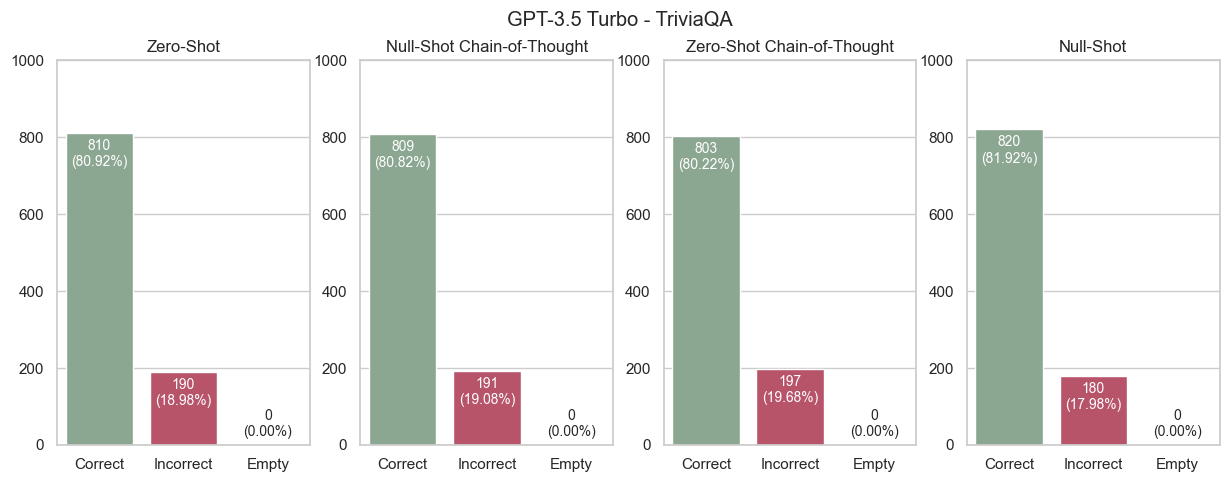

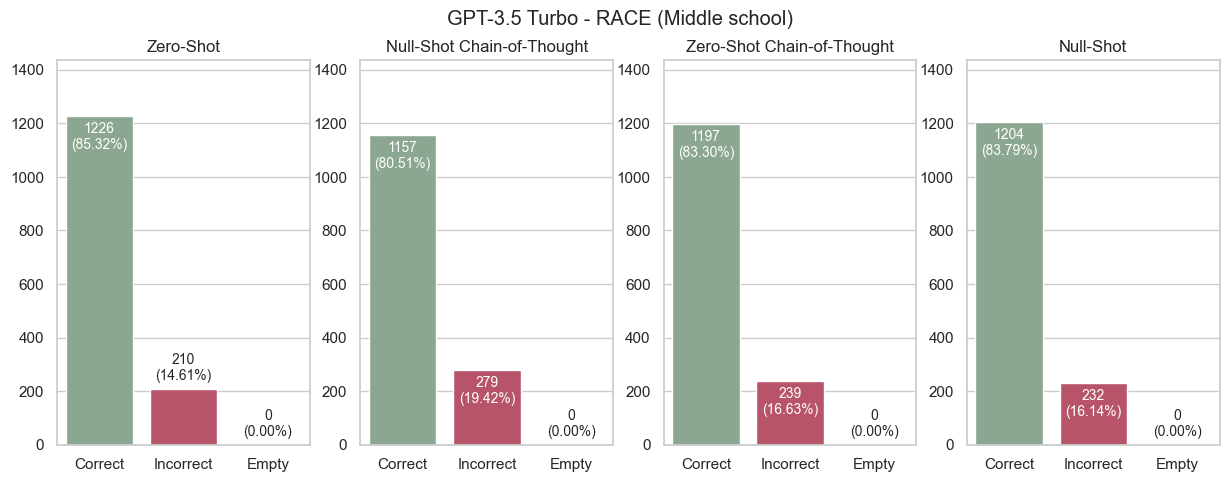

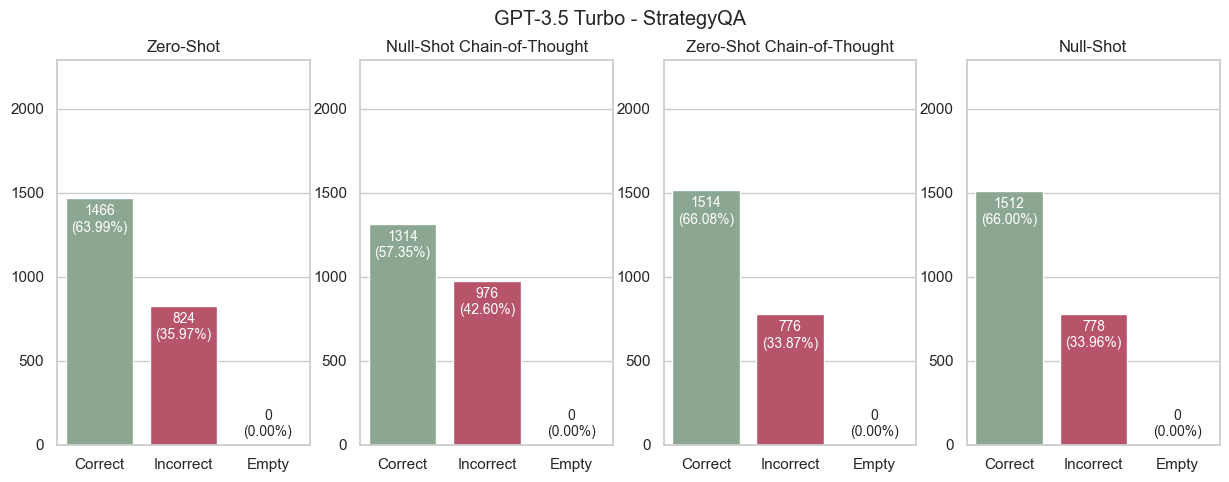

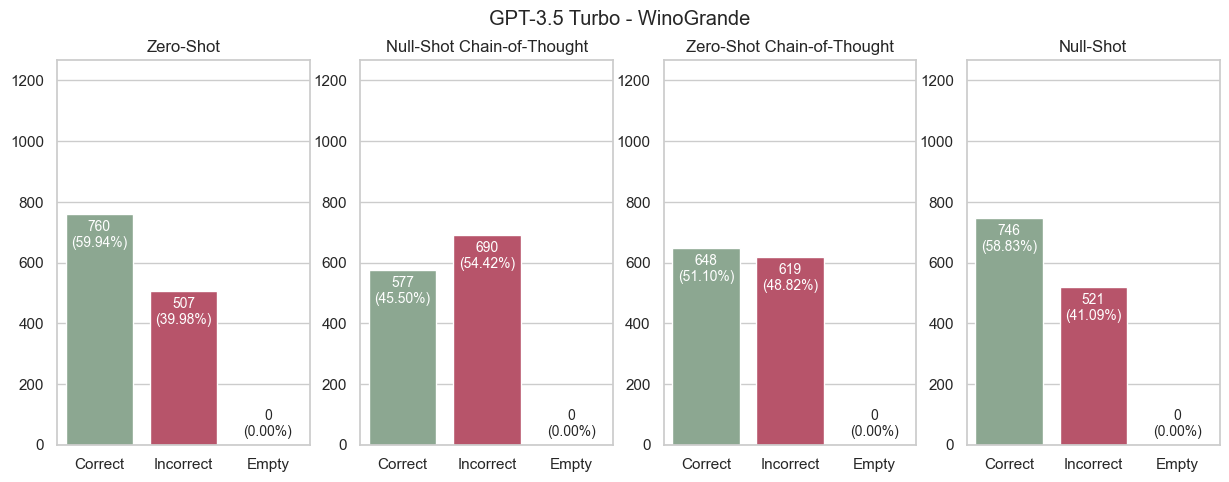

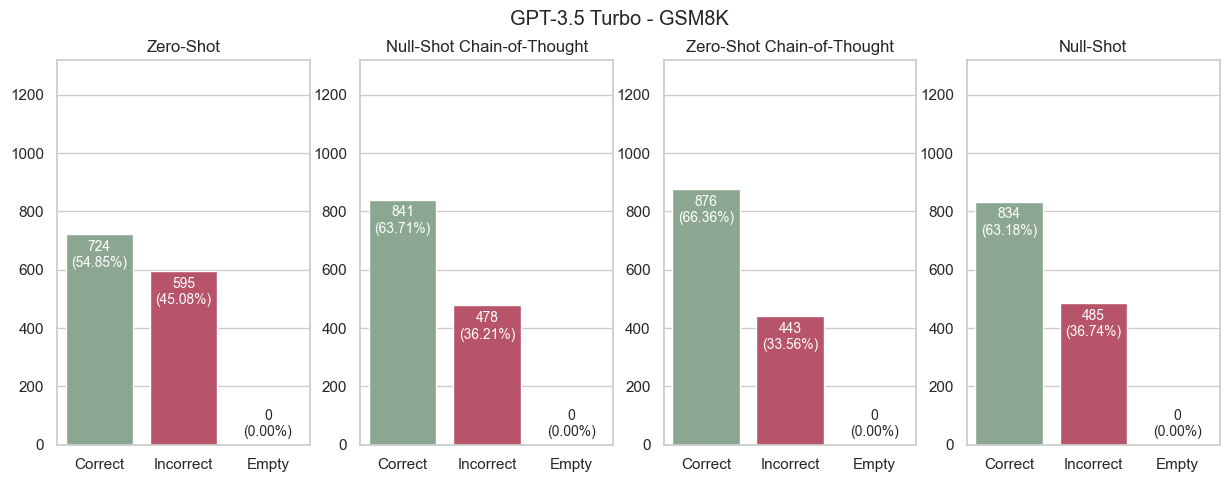

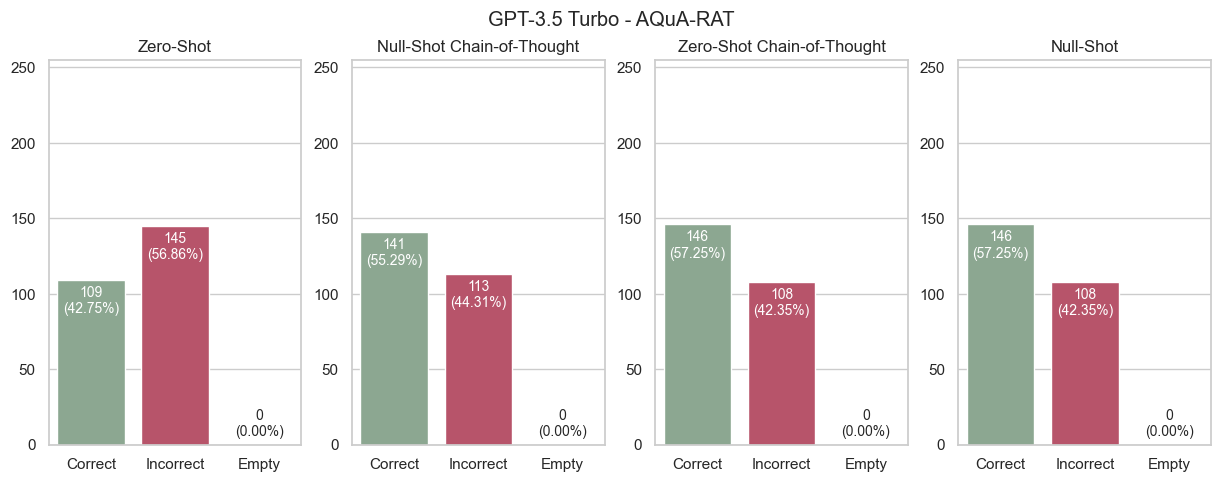

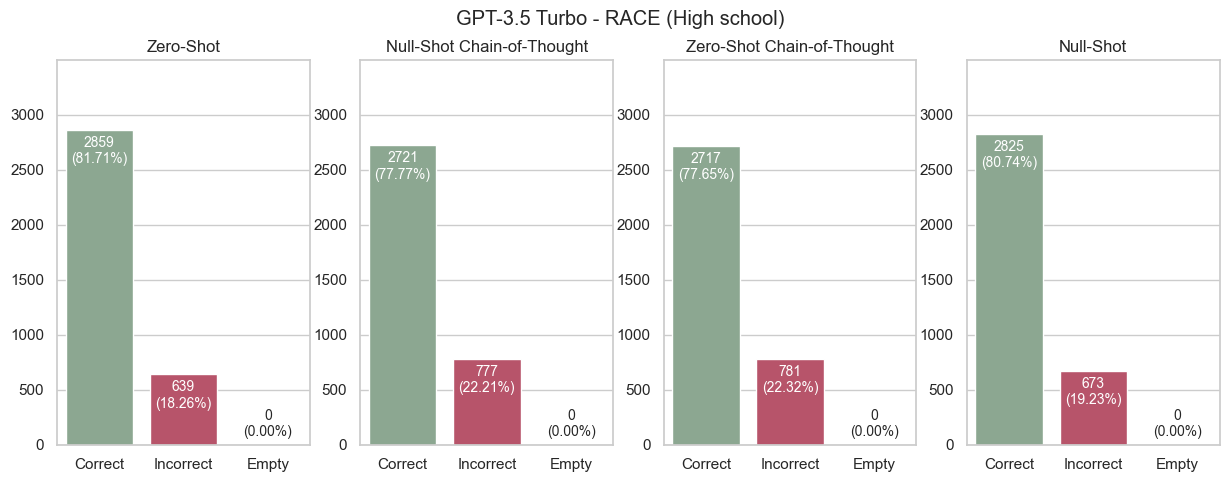

In [79]:
for model in plot_data:
    for task in plot_data[model]:
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))

        for i, pe in enumerate(plot_data[model][task]):
            xs = plot_data[model][task][pe].keys()
            ys = plot_data[model][task][pe].values()

            sns.barplot(x=xs, y=ys, ax=ax[i], hue=colors, legend=False, palette=colors)

            ax[i].set_ylim(0, summarized_error_categories[model][task][pe][
                "total"])  # Set the y-axis limit to the total number of records in each task

            ax[i].set_title(pe_names[pe])

            for p in ax[i].patches:
                percentage = '{:.2f}%'.format(
                    100 * p.get_height() / summarized_error_categories[model][task][pe]["total"])

                # Nice formatting for annotations
                if p.get_height() > 0:
                    if p.get_height() / summarized_error_categories[model][task][pe]["total"] > 0.15:
                        ax[i].annotate(f"{int(p.get_height())}\n({percentage})",
                                       (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                                       xytext=(0, -15), textcoords='offset points', fontsize=10, color="white")
                        continue

                ax[i].annotate(f"{int(p.get_height())}\n({percentage})",
                               (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                               xytext=(0, 15), textcoords='offset points', fontsize=10)

        fig.suptitle(f"{model_names[model]} - {task_names[task]}")
        Path("error_analysis").mkdir(exist_ok=True)
        plt.savefig(f"error_analysis/{model}_{task}.png", bbox_inches='tight')
        plt.show()

In [53]:
plot_data_df = {
    "model": [],
    "task": [],
    "method": [],
    "Correct": [],
    "Incorrect": [],
    "Empty": []
}

for model in plot_data:
    for task in plot_data[model]:
        for method in plot_data[model][task]:
            plot_data_df["model"].append(model)
            plot_data_df["task"].append(task)
            plot_data_df["method"].append(method)
            plot_data_df["Correct"].append(plot_data[model][task][method]["Correct"])
            plot_data_df["Incorrect"].append(plot_data[model][task][method]["Incorrect"])
            plot_data_df["Empty"].append(plot_data[model][task][method]["Empty"])

plot_data_df = pd.DataFrame(plot_data_df)

In [56]:
plot_data_df.head()

,model,task,method,Correct,Incorrect,Empty
0,palm-2-chat,anli,zero-shot,512,684,4
1,palm-2-chat,anli,null-shot-cot,509,686,5
2,palm-2-chat,anli,zero-shot-cot,522,677,1
3,palm-2-chat,anli,null-shot,520,675,5
4,palm-2-chat,triviaqa,zero-shot,702,250,48
...,...,...,...,...,...,...
123,gpt-3.5-turbo,aqua,null-shot,146,108,0
124,gpt-3.5-turbo,race-h,zero-shot,2859,639,0
125,gpt-3.5-turbo,race-h,null-shot-cot,2721,777,0
126,gpt-3.5-turbo,race-h,zero-shot-cot,2717,781,0
